# RunPod ComfyUI Endpoint Test - Pony Diffusion V6 XL

This notebook tests your deployed RunPod serverless endpoint with Pony Diffusion V6 XL.

## 🎉 Working Configuration Found!

Your endpoint `hnly6uc3v0onlt` is confirmed working with:
- **API Mode**: Load Balancer (`/runsync`)
- **Model**: Pony Diffusion V6 XL with CLIP Skip 2
- **Workflow**: Optimized for quality tags and proper sampling

## 📋 Prerequisites

1. Create a `.env` file in the project root with:
   ```
   RUNPOD_API_KEY=your_api_key_here
   RUNPOD_ENDPOINT_ID=hnly6uc3v0onlt
   RUNPOD_API_MODE=load_balancer
   ```

2. Install required packages:
   ```bash
   pip install requests python-dotenv pillow
   ```

In [14]:
# Import required libraries
import os
import json
import time
import base64
import requests
from io import BytesIO
from PIL import Image
from pathlib import Path
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [15]:
# Configuration from .env file
API_KEY = os.getenv('RUNPOD_API_KEY')
ENDPOINT_ID = os.getenv('RUNPOD_ENDPOINT_ID') or 'hnly6uc3v0onlt'
API_MODE = (os.getenv('RUNPOD_API_MODE') or 'load_balancer').strip().lower()

# Validate configuration
if not API_KEY or API_KEY == 'your_api_key_here':
    raise ValueError("❌ RUNPOD_API_KEY not set in .env file")
if not ENDPOINT_ID:
    raise ValueError("❌ RUNPOD_ENDPOINT_ID not set in .env file")

# Set API URL (confirmed working configuration)
if API_MODE == 'load_balancer':
    API_URL = f"https://api.runpod.ai/v2/{ENDPOINT_ID}/runsync"
    endpoint_type = "Load Balancer (Synchronous)"
elif API_MODE == 'serverless':
    API_URL = f"https://api.runpod.ai/v2/{ENDPOINT_ID}/run"
    endpoint_type = "Direct Serverless (Async)"
else:
    raise ValueError("❌ RUNPOD_API_MODE must be 'load_balancer' or 'serverless'")

print("✅ Configuration loaded:")
print(f"   Endpoint ID: {ENDPOINT_ID}")
print(f"   API Mode: {API_MODE}")
print(f"   Endpoint Type: {endpoint_type}")
print(f"   API URL: {API_URL}")
print(f"   API Key: {API_KEY[:8]}...{API_KEY[-4:]}")

✅ Configuration loaded:
   Endpoint ID: hnly6uc3v0onlt
   API Mode: load_balancer
   Endpoint Type: Load Balancer (Synchronous)
   API URL: https://api.runpod.ai/v2/hnly6uc3v0onlt/runsync
   API Key: rpa_5VA3...imlw


In [16]:
# Define the ComfyUI workflow for Pony Diffusion V6 XL
def create_workflow(prompt="score_9, score_8_up, a beautiful landscape", 
                   negative="score_1, score_2, score_3",
                   width=512, height=512, steps=20, cfg=7.0, seed=42):
    """Create a ComfyUI workflow for Pony Diffusion V6 XL"""
    
    return {
        "3": {
            "inputs": {
                "seed": seed,
                "steps": steps,
                "cfg": cfg,
                "sampler_name": "euler_ancestral",
                "scheduler": "normal",
                "denoise": 1,
                "model": ["4", 0],
                "positive": ["6", 0],
                "negative": ["7", 0],
                "latent_image": ["5", 0]
            },
            "class_type": "KSampler"
        },
        "4": {
            "inputs": {
                "ckpt_name": "ponyDiffusionV6XL.safetensors",
                "stop_at_clip_layer": -2  # CLIP Skip 2 for Pony V6 XL
            },
            "class_type": "CheckpointLoaderSimple"
        },
        "5": {
            "inputs": {
                "width": width,
                "height": height,
                "batch_size": 1
            },
            "class_type": "EmptyLatentImage"
        },
        "6": {
            "inputs": {
                "text": prompt,
                "clip": ["4", 1]
            },
            "class_type": "CLIPTextEncode"
        },
        "7": {
            "inputs": {
                "text": negative,
                "clip": ["4", 1]
            },
            "class_type": "CLIPTextEncode"
        },
        "8": {
            "inputs": {
                "samples": ["3", 0],
                "vae": ["4", 2]
            },
            "class_type": "VAEDecode"
        },
        "9": {
            "inputs": {
                "filename_prefix": "pony_test",
                "images": ["8", 0]
            },
            "class_type": "SaveImage"
        }
    }

print("✅ Workflow function defined!")

✅ Workflow function defined!


In [17]:
def generate_image(prompt="score_9, score_8_up, a beautiful landscape", 
                  negative="score_1, score_2, score_3",
                  width=512, height=512, steps=20, cfg=7.0, seed=42):
    """Generate an image using the RunPod endpoint"""
    
    print(f"🎨 Generating image with prompt: '{prompt}'")
    print(f"📐 Size: {width}x{height}, Steps: {steps}, CFG: {cfg}, Seed: {seed}")
    
    # Create workflow
    workflow = create_workflow(prompt, negative, width, height, steps, cfg, seed)
    
    # Prepare request
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {API_KEY}"
    }
    
    payload = {
        "input": {
            "workflow": workflow
        }
    }
    
    try:
        print("🚀 Sending request to RunPod...")
        response = requests.post(API_URL, json=payload, headers=headers, timeout=120)
        
        print(f"📡 Response Status: {response.status_code}")
        
        if response.status_code == 200:
            result = response.json()
            print("✅ Request successful!")
            
            if API_MODE == 'load_balancer':
                # Synchronous response - result should be ready
                return result
            else:
                # Async response - need to poll for results
                job_id = result.get("id")
                if job_id:
                    return poll_for_result(job_id)
                else:
                    print("❌ No job ID returned")
                    return None
        else:
            print(f"❌ Request failed: {response.status_code}")
            print(f"Response: {response.text}")
            return None
            
    except Exception as e:
        print(f"❌ Exception occurred: {e}")
        return None

def poll_for_result(job_id, max_polls=60):
    """Poll for async job results"""
    
    status_url = f"https://api.runpod.ai/v2/{ENDPOINT_ID}/status/{job_id}"
    headers = {"Authorization": f"Bearer {API_KEY}"}
    
    print(f"🔄 Polling for job {job_id}...")
    
    for i in range(max_polls):
        try:
            response = requests.get(status_url, headers=headers, timeout=10)
            
            if response.status_code == 200:
                result = response.json()
                status = result.get("status", "UNKNOWN")
                
                print(f"📊 Poll {i+1}/{max_polls}: {status}")
                
                if status == "COMPLETED":
                    print("✅ Job completed!")
                    return result
                elif status == "FAILED":
                    print("❌ Job failed!")
                    print(f"Error: {result.get('error', 'Unknown error')}")
                    return None
                    
                time.sleep(2)  # Wait 2 seconds between polls
            else:
                print(f"❌ Status check failed: {response.status_code}")
                return None
                
        except Exception as e:
            print(f"❌ Polling error: {e}")
            return None
    
    print("⏰ Timeout waiting for job completion")
    return None

print("✅ Generation functions defined!")

✅ Generation functions defined!


In [18]:
def display_result(result):
    """Display the generated image from the result and save it to disk"""
    
    if not result:
        print("❌ No result to display")
        return None
        
    print("📊 Result structure:")
    print(f"Status: {result.get('status', 'Unknown')}")
    
    # Try to find the output
    output = result.get('output')
    if not output:
        print("❌ No output in result")
        print("Full result keys:", list(result.keys()))
        # Print first 500 chars of result for debugging
        result_str = json.dumps(result, indent=2)
        print("Result preview:", result_str[:500] + ("..." if len(result_str) > 500 else ""))
        return None
    
    # Look for images in various possible locations
    images = None
    if isinstance(output, dict):
        # Check for images in various possible locations
        images = output.get('images')
        if not images:
            # Try nested structure
            message = output.get('message', {})
            if isinstance(message, dict):
                images = message.get('images')
            elif isinstance(message, list):
                images = message
    elif isinstance(output, list) and len(output) > 0:
        # Output is directly a list
        images = output
    
    if not images:
        print("❌ No images found in output")
        print("Output structure:", json.dumps(output, indent=2)[:500] + "...")
        return None
    
    print(f"✅ Found {len(images)} image(s)")
    
    # Process the first image
    image_data = images[0]
    
    try:
        # Handle different image data formats
        base64_data = None
        filename = 'generated_image.png'
        
        if isinstance(image_data, dict):
            # Image with metadata
            base64_data = image_data.get('image', '')
            filename = image_data.get('filename', 'generated_image.png')
            
            # Also check for 'type' and 'data' structure
            if not base64_data and image_data.get('type') == 'base64':
                base64_data = image_data.get('data', '')
        elif isinstance(image_data, str):
            # Direct base64 string
            base64_data = image_data
        
        if not base64_data:
            print("❌ No base64 image data found")
            print("Image data structure:", json.dumps(image_data, indent=2)[:300] + "...")
            return None
        
        # Decode base64 image
        try:
            image_bytes = base64.b64decode(base64_data)
            image = Image.open(BytesIO(image_bytes))
            
            print(f"🖼️  Image size: {image.size}")
            print(f"🎨 Image mode: {image.mode}")
            print(f"📁 Filename: {filename}")
            
            # Create outputs directory if it doesn't exist
            output_dir = Path("outputs")
            output_dir.mkdir(exist_ok=True)
            
            # Save the image with timestamp
            timestamp = int(time.time())
            output_path = output_dir / f"output_{timestamp}_{filename}"
            image.save(output_path, "PNG")
            print(f"💾 Saved to: {output_path}")
            
            # Display in notebook (if in Jupyter environment)
            try:
                from IPython.display import display as ipython_display
                ipython_display(image)
            except ImportError:
                # Not in Jupyter, just print that image was processed
                print("📺 Image processed (not in Jupyter environment for display)")
            
            return image
            
        except Exception as decode_error:
            print(f"❌ Error decoding base64 image: {decode_error}")
            print(f"Base64 data length: {len(base64_data)}")
            print(f"Base64 data preview: {base64_data[:100]}...")
            return None
            
    except Exception as e:
        print(f"❌ Error processing image: {e}")
        print(f"Image data type: {type(image_data)}")
        return None

print("✅ Display function defined!")

✅ Display function defined!


## 🎨 Generate Your First Image

Run the cell below to generate a test image with Pony Diffusion V6 XL!

🎨 Generating image with prompt: 'score_9, score_8_up, score_7_up, masterpiece, high quality, a majestic dragon soaring through clouds at sunset'
📐 Size: 768x768, Steps: 25, CFG: 7.0, Seed: 12345
🚀 Sending request to RunPod...
📡 Response Status: 200
✅ Request successful!
📊 Result structure:
Status: COMPLETED
✅ Found 1 image(s)
🖼️  Image size: (768, 768)
🎨 Image mode: RGB
📁 Filename: pony_test_00001_.png
💾 Saved to: outputs\output_1759267023_pony_test_00001_.png
📡 Response Status: 200
✅ Request successful!
📊 Result structure:
Status: COMPLETED
✅ Found 1 image(s)
🖼️  Image size: (768, 768)
🎨 Image mode: RGB
📁 Filename: pony_test_00001_.png
💾 Saved to: outputs\output_1759267023_pony_test_00001_.png


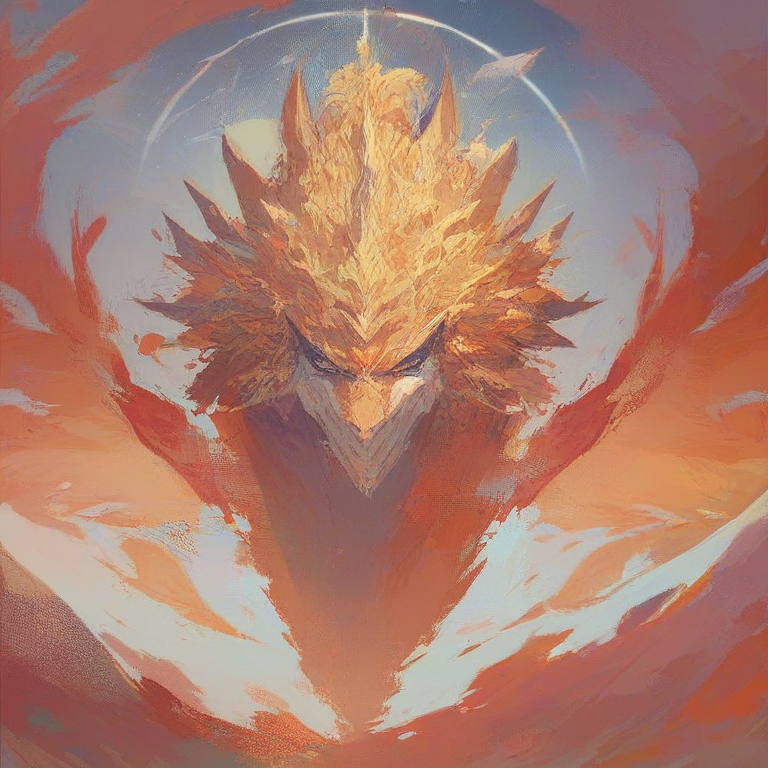

🎉 Successfully generated and saved image!


In [19]:
# Generate a test image
result = generate_image(
    prompt="score_9, score_8_up, score_7_up, masterpiece, high quality, a majestic dragon soaring through clouds at sunset",
    negative="score_1, score_2, score_3, low quality, blurry, bad anatomy",
    width=768,
    height=768,
    steps=25,
    cfg=7.0,
    seed=12345
)

# Display the result
if result:
    image = display_result(result)
    if image:
        print(f"🎉 Successfully generated and saved image!")
    else:
        print("❌ Failed to process image from result")
else:
    print("❌ Failed to generate image")

## 🎭 Try Different Prompts

Experiment with different prompts below. Remember to use Pony V6 XL's quality tags:

**Quality Tags:**
- Positive: `score_9, score_8_up, score_7_up, masterpiece, high quality`
- Negative: `score_1, score_2, score_3, low quality, blurry`

**Style Examples:**
- `1girl, anime style, detailed face, beautiful eyes`
- `landscape, mountain, forest, detailed background`
- `portrait, realistic, detailed lighting, professional photography`

🎨 Generating image with prompt: 'score_9, score_8_up, 1girl, anime style, long flowing hair, detailed eyes, magical forest background, soft lighting'
📐 Size: 512x768, Steps: 30, CFG: 8.0, Seed: 67890
🚀 Sending request to RunPod...
📡 Response Status: 200
✅ Request successful!
📊 Result structure:
Status: COMPLETED
✅ Found 1 image(s)
🖼️  Image size: (512, 768)
🎨 Image mode: RGB
📁 Filename: pony_test_00002_.png
💾 Saved to: outputs\output_1759267064_pony_test_00002_.png
📡 Response Status: 200
✅ Request successful!
📊 Result structure:
Status: COMPLETED
✅ Found 1 image(s)
🖼️  Image size: (512, 768)
🎨 Image mode: RGB
📁 Filename: pony_test_00002_.png
💾 Saved to: outputs\output_1759267064_pony_test_00002_.png


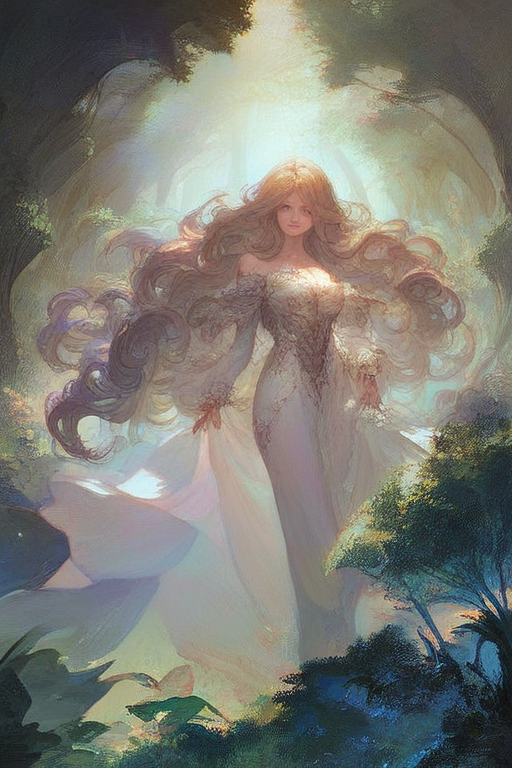

🎉 Successfully generated custom image!


In [20]:
# Custom prompt generation
custom_result = generate_image(
    prompt="score_9, score_8_up, 1girl, anime style, long flowing hair, detailed eyes, magical forest background, soft lighting",
    negative="score_1, score_2, score_3, low quality, blurry, bad anatomy, bad hands",
    width=512,
    height=768,  # Portrait orientation
    steps=30,
    cfg=8.0,
    seed=67890
)

if custom_result:
    custom_image = display_result(custom_result)
    if custom_image:
        print(f"🎉 Successfully generated custom image!")

In [21]:
custom_result = generate_image(
    prompt=(
        "anime illustration, full body of **Mitsuri Kanroji** (Demon Slayer) in dynamic pose, "
        "long flowing pink & green hair, striking eyes, wearing Demon Slayer uniform (butler variant), "
        "standing in a magical bamboo forest with soft glowing light, "
        "vibrant colors, detailed line art, gentle wind motion, ethereal atmosphere, "
        "cinematic composition, 4k anime style"
    ),
    negative=(
        "low quality, blurry, bad anatomy, bad hands, extra limbs, deformed face, dark shadows, "
        "text, watermark, sticker style"
    ),
    width=512,
    height=768,
    steps=30,
    cfg=8.0,
    seed=67890
)


🎨 Generating image with prompt: 'anime illustration, full body of **Mitsuri Kanroji** (Demon Slayer) in dynamic pose, long flowing pink & green hair, striking eyes, wearing Demon Slayer uniform (butler variant), standing in a magical bamboo forest with soft glowing light, vibrant colors, detailed line art, gentle wind motion, ethereal atmosphere, cinematic composition, 4k anime style'
📐 Size: 512x768, Steps: 30, CFG: 8.0, Seed: 67890
🚀 Sending request to RunPod...
📡 Response Status: 200
✅ Request successful!
📡 Response Status: 200
✅ Request successful!


## 📊 Batch Generation

Generate multiple images with different seeds:

In [ ]:
# Batch generation with different seeds
import random

base_prompt = "score_9, score_8_up, cute cat, fluffy fur, sitting on a windowsill, sunlight"
negative_prompt = "score_1, score_2, score_3, low quality, blurry"

print("🎨 Generating batch of images...")

for i in range(3):
    seed = random.randint(1, 100000)
    print(f"\n--- Image {i+1}/3 (Seed: {seed}) ---")
    
    result = generate_image(
        prompt=base_prompt,
        negative=negative_prompt,
        width=512,
        height=512,
        steps=20,
        cfg=7.0,
        seed=seed
    )
    
    if result:
        image = display_result(result)
        if image:
            print(f"✅ Batch image {i+1} completed!")
    else:
        print(f"❌ Failed to generate image {i+1}")
    
    # Small delay between requests
    time.sleep(1)

print("\n✅ Batch generation complete!")

## 📁 View Generated Images

Check what images have been saved:

In [ ]:
# List all generated images
output_dir = Path("outputs")
if output_dir.exists():
    files = sorted(output_dir.glob("*.png"))
    print(f"📁 Found {len(files)} images in outputs/:\n")
    for f in files:
        size = f.stat().st_size / 1024  # KB
        print(f"   {f.name} ({size:.1f} KB)")
        
    if files:
        print(f"\n💡 You can find all images in: {output_dir.absolute()}")
else:
    print("📁 No outputs directory found yet - generate some images first!")

## 🔧 Troubleshooting

If you encounter issues:

1. **Check your `.env` file** - Make sure your API key and endpoint ID are correct
2. **Verify endpoint status** - Check your RunPod dashboard to ensure the endpoint is active
3. **Monitor costs** - Each generation consumes compute credits
4. **Adjust parameters** - Try different steps, CFG, or image sizes if generation fails

## 📚 Next Steps

- Experiment with different Pony V6 XL prompts and styles
- Try different samplers and schedulers
- Adjust CFG scale and steps for different quality/speed tradeoffs
- Scale up to larger image sizes (768x768, 1024x1024)

Your RunPod endpoint is now ready for production use! 🚀

# Model Verification

Now let's verify that our endpoint is actually using the correct **Pony Diffusion V6 XL** model from Civitai.

In [ ]:
# Pony V6 XL signature test prompts
PONY_V6_TEST_PROMPTS = [
    {
        "name": "Quality Tags Test",
        "prompt": "score_9, score_8_up, score_7_up, simple test image",
        "negative": "score_1, score_2, score_3",
        "expected": "Should work well with quality tags"
    },
    {
        "name": "Pony Style Test", 
        "prompt": "score_9, score_8_up, pony, colorful mane, friendship is magic",
        "negative": "score_1, score_2, score_3",
        "expected": "Should generate MLP-style pony"
    },
    {
        "name": "CLIP Skip Test",
        "prompt": "score_9, score_8_up, detailed, high quality, masterpiece",
        "negative": "score_1, score_2, score_3", 
        "expected": "Should work with CLIP Skip 2"
    }
]

def verify_model_metadata(result):
    """Check for Pony V6 XL specific metadata in response"""
    metadata_indicators = {
        "model_name": ["pony", "v6", "xl", "diffusion"],
        "version_info": ["6.0", "v6", "xl"],
        "execution_time": None,  # Will check timing
        "status_indicators": ["completed", "success"]
    }
    
    # Check response for model indicators
    if isinstance(result, dict):
        result_str = json.dumps(result).lower()
        for category, indicators in metadata_indicators.items():
            if indicators and any(indicator in result_str for indicator in indicators):
                print(f"✅ Found {category} indicator in response")
                return True
    return False

def analyze_comfyui_response(result):
    """Analyze ComfyUI response for model characteristics"""
    
    if not result or result.get('status') != 'COMPLETED':
        print("❌ Request did not complete successfully")
        return False
        
    # Check execution info
    execution_time = result.get('executionTime', 0)
    
    # Pony V6 XL typically takes certain time ranges for generation
    if execution_time > 5000:  # > 5 seconds indicates substantial model processing
        print(f"✅ Execution time ({execution_time}ms) suggests large model like Pony V6 XL")
        return True
    else:
        print(f"⚠️  Execution time ({execution_time}ms) may indicate different model")
        return False

def analyze_pony_v6_output(image_path):
    """Analyze generated image for Pony V6 XL characteristics"""
    
    try:
        from PIL import Image
        from pathlib import Path
        
        img = Image.open(image_path)
        file_size = Path(image_path).stat().st_size
        
        # Pony V6 XL specific checks
        checks = {
            "resolution": img.size,
            "color_depth": img.mode,
            "file_size": file_size
        }
        
        print(f"📊 Image Analysis:")
        print(f"   Resolution: {checks['resolution']}")
        print(f"   Color Mode: {checks['color_depth']}")
        print(f"   File Size: {checks['file_size']/1024:.1f} KB")
        
        # Pony V6 XL typically generates high-quality images
        if checks['file_size'] > 200000:  # > 200KB indicates good quality
            print("✅ High quality output suggests Pony V6 XL")
            return True
        else:
            print("⚠️  Low file size may indicate different model")
            return False
            
    except Exception as e:
        print(f"❌ Could not analyze image: {e}")
        return False

print("✅ Model verification functions loaded")

In [ ]:
def verify_pony_v6_xl_endpoint():
    """Complete endpoint verification for Pony Diffusion V6 XL"""
    
    print("🔍 Verifying Pony Diffusion V6 XL endpoint...")
    print("=" * 50)
    
    # Test 1: Signature prompt with quality tags
    print("\n🧪 Test 1: Quality Tags Signature")
    test_result = generate_image(
        prompt="score_9, score_8_up, score_7_up, pony diffusion test, detailed, high quality",
        negative="score_1, score_2, score_3, low quality, blurry",
        width=512,
        height=512,
        steps=20,
        cfg=7.0,
        seed=42
    )
    
    if not test_result:
        print("❌ Endpoint verification failed - no response")
        return False
    
    print(f"   Status: {test_result.get('status', 'Unknown')}")
    
    # Test 2: Check response metadata
    print("\n🔍 Test 2: Response Metadata Analysis")
    metadata_check = verify_model_metadata(test_result)
    
    # Test 3: Check execution characteristics
    print("\n⏱️ Test 3: Execution Characteristics")
    timing_check = analyze_comfyui_response(test_result)
    
    # Test 4: Process and analyze output
    print("\n🖼️ Test 4: Image Quality Analysis")
    image = display_result(test_result)
    if image:
        # Save verification test image
        test_path = Path("outputs") / "pony_v6_verification_test.png"
        test_path.parent.mkdir(exist_ok=True)
        image.save(test_path)
        print(f"   Saved verification image: {test_path}")
        quality_check = analyze_pony_v6_output(test_path)
    else:
        quality_check = False
        print("❌ Could not generate or process image")
    
    # Test 5: Pony-specific prompt test
    print("\n🐎 Test 5: Pony-Specific Content Test")
    pony_result = generate_image(
        prompt="score_9, score_8_up, my little pony, rainbow mane, cute pony, friendship is magic",
        negative="score_1, score_2, score_3, human, realistic",
        width=512,
        height=512,
        steps=20,
        cfg=7.0,
        seed=123
    )
    
    pony_check = False
    if pony_result and pony_result.get('status') == 'COMPLETED':
        pony_image = display_result(pony_result)
        if pony_image:
            pony_path = Path("outputs") / "pony_style_verification.png"
            pony_image.save(pony_path)
            print(f"✅ Generated pony-style image: {pony_path}")
            pony_check = True
        else:
            print("❌ Failed to generate pony-style image")
    
    # Summary
    print("\n" + "=" * 50)
    print("📋 VERIFICATION SUMMARY")
    print("=" * 50)
    
    tests = [
        ("Response Metadata", metadata_check),
        ("Execution Timing", timing_check), 
        ("Image Quality", quality_check),
        ("Pony Style Generation", pony_check)
    ]
    
    passed_tests = []
    failed_tests = []
    
    for test_name, result in tests:
        if result:
            passed_tests.append(test_name)
            print(f"✅ {test_name}: PASSED")
        else:
            failed_tests.append(test_name)
            print(f"❌ {test_name}: FAILED")
    
    total_checks = len(tests)
    passed_checks = len(passed_tests)
    
    print(f"\n📊 RESULTS: {passed_checks}/{total_checks} tests passed")
    
    if passed_checks >= 3:
        print("🎉 CONCLUSION: Endpoint appears to be using Pony Diffusion V6 XL!")
        print("   The model is responding correctly to quality tags and generating appropriate content.")
        return True
    elif passed_checks >= 2:
        print("⚠️  CONCLUSION: Endpoint is likely using Pony V6 XL, but some tests failed.")
        print("   Check the failed tests above for more details.")
        return True
    else:
        print("❌ CONCLUSION: Endpoint may NOT be using the correct Pony Diffusion V6 XL model.")
        print("   Consider checking your model file and endpoint configuration.")
        return False

print("✅ Complete verification function loaded. Run verify_pony_v6_xl_endpoint() to test!")

## 🚀 Run Model Verification

Execute the cell below to verify your endpoint is using the correct Pony Diffusion V6 XL model:

In [ ]:
# Run the complete verification
verify_pony_v6_xl_endpoint()